In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mplt
#import geopandas
pd.options.display.max_columns = None
%matplotlib inline

In [3]:
data=pd.read_csv('Entrenamieto_ECI_2020.csv')

Eliminamos las columnas con único o ningún valor:

In [4]:
def dropUniqueValueCols(dataframe):
    i=0
    eliminadas=[]
    for col in dataframe.columns:
        if len(dataframe[[col]].value_counts())==1 or len(dataframe[[col]].value_counts())==0:
            dataframe.drop([col],axis=1,inplace=True)
            i+=1
            eliminadas.append(col)
    print('{} COLUMNAS ELIMINADAS:'.format(i))
    for col in eliminadas:
        print('   {}'.format(col))
        
#Drop de columnas con único o ningún valor
dropUniqueValueCols(data)

5 COLUMNAS ELIMINADAS:
   Submitted_for_Approval
   Last_Activity
   ASP_(converted)_Currency
   Actual_Delivery_Date
   Prod_Category_A


A continuación eliminamos la columna 'ASP' porque ya existe otra equivalente cuyos valores son los de 'ASP' convertidos a dólares. Esta última es 'ASP_(Converted)' y la renombramos como 'ASP(USD)'. Ademas eliminamos 'ID' porque se trata de un identificador único y por este motivo no es de interés para nuestro análisis. Corregimos el nombre de la columna 'Source', pues contenía un espacio en blanco. Y por último corregimos los datos de las columnas 'Region' y 'Territory'.

In [5]:
#Eliminamos ASP porque ya existe una columna convertida a dólares ASP_(Converted) y también Opportunity_ID porque existe Opportunity_Name (tienen la misma info)
data=data.drop(columns=['ID','ASP','ASP_Currency','Opportunity_ID'])
#Renombramos ASP_(Converted) como ASP(USD)
data=data.rename(columns={'ASP_(converted)':'ASP(USD)'})
#Corrección del nombre de columna 'Source'
data=data.rename(columns={'Source ': 'Source'})
#Corrección de datos 'Region' y 'Territory':
data.loc[data['Region']=='Japan',['Territory']]='Japan'
data.loc[data['Region']=='Japan',['Region']]='APAC'
data.loc[data['Region']=='Middle East',['Region']]='EMEA'
data.loc[(data.Region=='EMEA')&\
         ((data.Territory=='SE America')|(data.Territory=='Central America')|(data.Territory=='South America')),['Region']]='Americas'

En la siguiente celda reemplazamos los valores 'None' por valores NaN y asignamos los tipos de variables correctos para las que fueron, al cargar el .csv, identificadas como object.

In [6]:
#Reemplaza todos los valores 'None' por valores NaN
for col in data.columns:
    if data.dtypes[col]=='object':
        data.loc[data[col]=='None',[col]] = np.nan
#....................................

#Cambio del tipo de variables:

# categoricas=['Region','Territory','Bureaucratic_Code','Source','Billing_Country','Account_Name','Opportunity_Name',\
#              'Account_Owner','Opportunity_Owner','Account_Type','Opportunity_Type','Quote_Type','Delivery_Terms','Brand', 'Product_Type','Size',\
#              'Product_Category_B','Currency','Last_Modified_By','Product_Family', 'Product_Name',\
#              'Delivery_Quarter','Total_Taxable_Amount_Currency','Total_Amount_Currency', 'Stage']
# data[categoricas]=data[categoricas].astype('category')

binarias=['Pricing, Delivery_Terms_Quote_Appr','Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval','Bureaucratic_Code_0_Approved']
data[binarias]=data[binarias].astype('boolean')

flotantes=['Price','Total_Taxable_Amount','Total_Amount','ASP(USD)']
for col in flotantes:
     data[col]=pd.to_numeric(data[col],errors='coerce')

enteros=['Sales_Contract_No','Delivery_Year','TRF']
for col in enteros:
     data[col]=pd.to_numeric(data[col],errors='coerce',downcast='integer')

fechas=['Account_Created_Date', 'Opportunity_Created_Date', 'Quote_Expiry_Date','Last_Modified_Date','Planned_Delivery_Start_Date',\
        'Planned_Delivery_End_Date','Month']
data[fechas]=data[fechas].astype('datetime64[ns]')
#....................................
#data

In [7]:
#data=data.loc[data['ASP(USD)']<2,:]
#data=data.loc[(data['Total_Amount']!=0)&(~data['Total_Amount'].isnull()),:]

In [8]:
#Porcentaje de datos por columna
def dataPercent(df):
    dataPercent=df.agg(lambda x: (1-x.isnull().mean())*100).to_frame()
    dataPercent=dataPercent.round(2)
    dataPercent=dataPercent.transpose()
    return dataPercent
percent=dataPercent(data)
percent=percent.reset_index()
percent=percent.rename(columns={'index':'Variable',0:'% de datos'})
percent

,Variable,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP(USD),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,0,100.0,95.35,100.0,100.0,100.0,100.0,100.0,100.0,43.96,99.84,100.0,100.0,58.85,100.0,100.0,99.34,100.0,100.0,100.0,100.0,6.11,5.97,5.78,6.01,2.1,5.28,72.71,100.0,100.0,100.0,100.0,81.06,100.0,99.56,100.0,100.0,100.0,100.0,100.0,99.65,100.0,100.0,100.0


Eliminamos “Brand”, “Product_Type”, “Size”, “Price” “Product_Category_B” y “Currency” por su bajo porcentaje de datos.

In [9]:
data=data.drop(columns=['Brand', 'Product_Type', 'Size', 'Price', 'Product_Category_B', 'Currency'])
data

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP(USD),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,EMEA,NaN,True,True,True,True,Bureaucratic_Code_4,2015-06-16,NaN,Netherlands,Account_Name_619,Opportunity_Name_12598,NaN,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,2016-01-30,2016-06-13,Person_Name_18,Product_Family_77,Product_Name_99,0.58817,2016-05-01,2016-06-30,2016-05-01,Q2,2016,10,EUR,5272800.00,EUR,5272800.0,Closed Lost
1,EMEA,NaN,False,False,False,False,Bureaucratic_Code_4,2015-06-16,NaN,Netherlands,Account_Name_619,Opportunity_Name_12600,39.0,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,2016-01-20,2016-01-15,Person_Name_20,Product_Family_77,Product_Name_100,0.59948,2016-01-18,2016-01-20,2016-01-01,Q1,2016,0,EUR,48230.00,EUR,48230.0,Closed Won
2,Americas,NW America,False,False,False,False,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,760.0,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,2015-12-08,2016-09-30,2016-09-29,Person_Name_8,Product_Family_81,Product_Name_91,0.48000,2016-01-25,2016-01-25,2016-01-01,Q1,2016,0,USD,83865.60,USD,83865.6,Closed Won
3,Americas,NW America,True,False,True,False,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_415,NaN,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,NaT,2018-03-27,Person_Name_8,Product_Family_209,Product_Name_432,0.53000,2018-02-01,2018-03-31,2018-02-01,Q1,2018,14,USD,7421881.50,USD,7421881.5,Closed Lost
4,Americas,NW America,True,False,True,False,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,NaN,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,2017-06-02,2018-03-27,Person_Name_8,Product_Family_209,Product_Name_432,0.53000,2018-02-01,2018-02-28,2018-02-01,Q1,2018,25,USD,13357192.50,USD,13357192.5,Closed Lost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,EMEA,Austria,True,True,True,True,Bureaucratic_Code_4,2016-01-15,Source_7,Austria,Account_Name_726,Opportunity_Name_9245,44.0,Person_Name_13,Person_Name_13,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-04,NaT,2016-01-19,Person_Name_13,Product_Family_85,Product_Name_111,0.58817,2016-03-21,2016-03-25,2016-03-01,Q1,2016,0,EUR,103350.00,EUR,299715.0,Closed Won
16943,EMEA,Austria,True,True,True,True,Bureaucratic_Code_4,2016-01-15,Source_7,Austria,Account_Name_726,Opportunity_Name_9245,44.0,Person_Name_13,Person_Name_13,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-04,NaT,2016-01-19,Person_Name_13,Product_Family_85,Product_Name_111,0.58817,2016-04-04,2016-04-08,2016-04-01,Q2,2016,0,EUR,93015.00,EUR,299715.0,Closed Won
16944,EMEA,Austria,True,True,True,True,Bureaucratic_Code_4,2016-01-15,Source_7,Austria,Account_Name_726,Opportunity_Name_9245,44.0,Person_Name_13,Person_Name_13,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-04,NaT,2016-01-19,Person_Name_13,Product_Family_85,Product_Name_111,0.58817,2016-03-28,2016-03-31,2016-03-01,Q1,2016,0,EUR,103350.00,EUR,299715.0,Closed Won
16945,Americas,NE America,True,Tr

#### Conversión a dólares de Total_Amount

In [10]:
#Creamos columnas con año y trismestre de la última modificación de la oportunidad
data['Last_Modified_Year']=data['Last_Modified_Date'].dt.year
data.loc[data['Last_Modified_Date'].dt.month<=3,['Last_Modified_Quarter']]='Q1'
data.loc[(data['Last_Modified_Date'].dt.month>=4)&(data['Last_Modified_Date'].dt.month<=6),['Last_Modified_Quarter']]='Q2'
data.loc[(data['Last_Modified_Date'].dt.month>=7)&(data['Last_Modified_Date'].dt.month<=9),['Last_Modified_Quarter']]='Q3'
data.loc[data['Last_Modified_Date'].dt.month>=10,['Last_Modified_Quarter']]='Q4'
#data

La columna 'Total_Amount' tiene sus valores en diferentes divisas, lo que haremos a continuación será convertirlos todos a dólares. Para ello utilizamos datos históricos de la relación entre las divisas obtenidos de la página web: https://es.investing.com/

In [11]:
data['Total_Amount_Currency'].value_counts()

USD    7361
JPY    4522
EUR    4503
AUD     556
GBP       5
Name: Total_Amount_Currency, dtype: int64

Analizamos primero en que época del año fueron realizadas las operaciones con Euros para seleccionar los datos de convertibilidad de la web mencionada. Luego de descargar los datos, calculamos un promedio del factor de convertibilidad para los trimestre de cada año y repetimos el proceso para las demas divisas.

In [12]:
date_eur=data.loc[data['Total_Amount_Currency']=='EUR',['Last_Modified_Year','Last_Modified_Quarter']].value_counts().to_frame().sort_values('Last_Modified_Year')
date_eur=date_eur.reset_index()
date_eur=date_eur.drop([0],axis=1)
#date_eur

In [13]:
def factor_to_usd(csv,divisa):
    to_usd=pd.read_csv(csv, parse_dates=['Fecha'], decimal=',',dayfirst=True)
    to_usd['mean']=(to_usd['Máximo']+to_usd['Mínimo'])/2
    to_usd['Last_Modified_Year']=to_usd['Fecha'].dt.year
    to_usd.loc[to_usd['Fecha'].dt.month<4,['Last_Modified_Quarter']]='Q1'
    to_usd.loc[(to_usd['Fecha'].dt.month>3)&(to_usd['Fecha'].dt.month<7),['Last_Modified_Quarter']]='Q2'
    to_usd.loc[(to_usd['Fecha'].dt.month>6)&(to_usd['Fecha'].dt.month<10),['Last_Modified_Quarter']]='Q3'
    to_usd.loc[to_usd['Fecha'].dt.month>9,['Last_Modified_Quarter']]='Q4'
    to_usd=to_usd[['mean','Last_Modified_Quarter','Last_Modified_Year']]
    to_usd_mean=to_usd.groupby(['Last_Modified_Year','Last_Modified_Quarter']).agg({'mean':'mean'}).reset_index().round(2)
    to_usd_mean=to_usd_mean.rename(columns={'mean':'factor_to_USD'})
    to_usd_mean['Last_Modified_Quarter']=to_usd_mean['Last_Modified_Quarter'].astype('category')
    to_usd_mean['Total_Amount_Currency']=divisa
    return to_usd_mean

In [14]:
eur_usd=factor_to_usd('EUR_USD_2015_2018.csv','EUR')
eur_usd=eur_usd.merge(date_eur,how='right')
#eur_usd

In [15]:
date_jpy=data.loc[data['Total_Amount_Currency']=='JPY',['Last_Modified_Year','Last_Modified_Quarter']].value_counts().to_frame().sort_values('Last_Modified_Year')
date_jpy=date_jpy.reset_index()
date_jpy=date_jpy.drop([0],axis=1)
#date_jpy

In [16]:
jpy_usd=factor_to_usd('USD_JPY_2015_2018.csv','JPY')
jpy_usd['factor_to_USD']=1/jpy_usd['factor_to_USD']
jpy_usd=jpy_usd.merge(date_jpy,how='right')
#jpy_usd

In [17]:
date_aud=data.loc[data['Total_Amount_Currency']=='AUD',['Last_Modified_Year','Last_Modified_Quarter']].value_counts().to_frame().sort_values('Last_Modified_Year')
date_aud=date_aud.reset_index()
date_aud=date_aud.drop([0],axis=1)
#date_aud

In [18]:
aud_usd=factor_to_usd('AUD_USD_2016_2018.csv','AUD')
aud_usd=aud_usd.merge(date_aud,how='right')
#aud_usd

In [19]:
date_gbp=data.loc[data['Total_Amount_Currency']=='GBP',['Last_Modified_Year','Last_Modified_Quarter']].value_counts().to_frame().sort_values('Last_Modified_Year')
date_gbp=date_gbp.reset_index()
date_gbp=date_gbp.drop([0],axis=1)
#date_gbp

In [20]:
gbp_usd=factor_to_usd('GBP_USD_2016.csv','GBP')
gbp_usd=gbp_usd.merge(date_gbp,how='right')
#gbp_usd

In [21]:
date_usd=data.loc[data['Total_Amount_Currency']=='USD',['Last_Modified_Year','Last_Modified_Quarter']].value_counts().to_frame().sort_values('Last_Modified_Year')
date_usd=date_usd.reset_index()
date_usd=date_usd.drop([0],axis=1)
usd_usd=date_usd
usd_usd['factor_to_USD']=1
usd_usd['Total_Amount_Currency']='USD'
#usd_usd

A continuación concatenamos los dataframes generados para cada divisa y combinamos con el dataframe de 'Frío Frío' para luego poder convertir a dólares las variables 'Total_Amount' y 'Total_Taxable_Amount'

In [22]:
factor_to_usd_TotAm=eur_usd.append([aud_usd,jpy_usd,gbp_usd,usd_usd])
factor_to_usd_TotAm=factor_to_usd_TotAm.rename(columns={'factor_to_USD':'factor_to_USD_TotAm'})
factor_to_usd_TotTaxAm=factor_to_usd_TotAm.rename(columns={'Total_Amount_Currency':'Total_Taxable_Amount_Currency',\
                                                           'factor_to_USD_TotAm':'factor_to_USD_TotTaxAm'})
data=data.merge(factor_to_usd_TotAm,how='outer',on=['Last_Modified_Year','Last_Modified_Quarter','Total_Amount_Currency'])
data=data.merge(factor_to_usd_TotTaxAm,how='outer',on=['Last_Modified_Year','Last_Modified_Quarter','Total_Taxable_Amount_Currency'])

In [23]:
#Convertimos
data['Total_Amount(USD)']=data['Total_Amount']*data['factor_to_USD_TotAm']
data['Total_Taxable_Amount(USD)']=data['Total_Taxable_Amount']*data['factor_to_USD_TotTaxAm']

In [24]:
#Una vez convertidas las variables elimninamos las columnas de factor de convertibilidad
data=data.drop(['factor_to_USD_TotAm','factor_to_USD_TotTaxAm'],axis=1)

In [25]:
data

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP(USD),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Last_Modified_Year,Last_Modified_Quarter,Total_Amount(USD),Total_Taxable_Amount(USD)
0,EMEA,NaN,True,True,True,True,Bureaucratic_Code_4,2015-06-16,NaN,Netherlands,Account_Name_619,Opportunity_Name_12598,NaN,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,2016-01-30,2016-06-13,Person_Name_18,Product_Family_77,Product_Name_99,0.58817,2016-05-01,2016-06-30,2016-05-01,Q2,2016,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,2016,Q2,5958264.0,5958264.0
1,EMEA,Germany,True,True,True,True,Bureaucratic_Code_4,2015-12-15,Source_13,Germany,Account_Name_2000,Opportunity_Name_777,NaN,Person_Name_13,Person_Name_13,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_2,2015-12-17,2016-04-01,2016-04-08,Person_Name_13,Product_Family_77,Product_Name_98,0.55424,2016-05-01,2016-06-30,2016-05-01,Q2,2016,20,EUR,9809800.0,EUR,9809800.0,Closed Lost,2016,Q2,11085074.0,11085074.0
2,EMEA,Belgium,True,False,False,False,Bureaucratic_Code_5,2014-02-25,NaN,Belgium,Account_Name_825,Opportunity_Name_5376,NaN,Person_Name_18,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-18,2016-04-30,2016-06-17,Person_Name_18,Product_Family_77,Product_Name_96,0.58817,2016-06-01,2016-06-30,2016-06-01,Q2,2016,1,EUR,304200.0,EUR,304200.0,Closed Lost,2016,Q2,343746.0,343746.0
3,EMEA,NaN,True,False,True,False,Bureaucratic_Code_5,2014-02-25,NaN,Belgium,Account_Name_825,Opportunity_Name_5377,NaN,Person_Name_18,Person_Name_23,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-18,2016-01-30,2016-04-11,Person_Name_23,Product_Family_116,Product_Name_163,0.62210,2016-06-01,2016-06-30,2016-06-01,Q2,2016,1,EUR,500500.0,EUR,500500.0,Closed Lost,2016,Q2,565565.0,565565.0
4,EMEA,Germany,True,False,True,False,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_9280,NaN,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-01-20,NaT,2016-05-24,Person_Name_13,Product_Family_77,Product_Name_96,0.58817,2016-05-02,2016-05-27,2016-05-01,Q2,2016,1,EUR,473200.0,EUR,473200.0,Closed Lost,2016,Q2,534716.0,534716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,EMEA,United Kingdom,True,True,True,True,Bureaucratic_Code_4,2015-09-11,Source_7,United Kingdom,Account_Name_74,Opportunity_Name_4693,NaN,Person_Name_18,Person_Name_39,Account_Type_2,Opportunity_Type_20,Non Binding,Delivery_Terms_2,2015-09-11,2015-10-06,2016-09-05,Person_Name_39,Product_Family_77,Product_Name_97,0.57686,2016-03-04,2016-03-15,2016-03-01,Q1,2016,2,EUR,1021020.0,EUR,1531530.0,Closed Lost,2016,Q3,1143542.4,1715313.6
16943,EMEA,United Kingdom,True,True,True,True,Bureaucratic_Code_4,2015-09-11,Source_7,United Kingdom,Account_Name_74,Opportunity_Name_4693,NaN,Person_Name_18,Person_Name_39,Account_Type_2,Opportunity_Type_20,Non Binding,Delivery_Terms_2,2015-09-11,2015-10-06,2016-09-05,Person_Name_39,Product_Family_77,Product_Name_96,0.57686,2016-02-08,2016-02-18,2016-02-01,Q1,2016,1,EUR,510510.0,EUR,1531530.0,Closed Lost,2016,Q3,571771.2,1715313.6
16944,EMEA,Germany,True,True,True,True,Bureaucratic_Code_4,2013-10-11,Source_10,Germany,Account_Name_1793,Opportunity_Name_9663,NaN,Person_Name_4,

In [26]:
data['Total_Amount(USD)']=data['Total_Amount(USD)']/1000000
data['Total_Taxable_Amount(USD)']=data['Total_Taxable_Amount(USD)']/1000000
data=data.rename(columns={'Total_Amount(USD)':'Total_Amount(Million_USD)','Total_Taxable_Amount(USD)':'Total_Taxable_Amount(Million_USD)'})

### Distribución de oportunidades en el tiempo por región

Text(159.0, 0.5, 'Año de creación de la oportunidad')

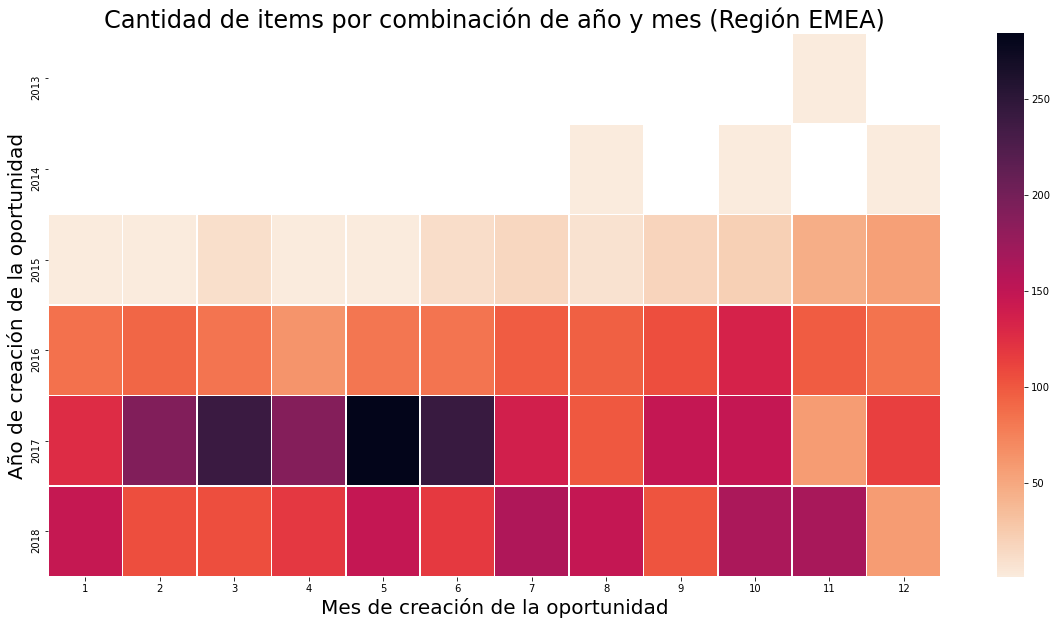

In [27]:
data['linea_oportunidad'] = 1
data['MesUltMod']=data['Opportunity_Created_Date'].dt.month
data['AnioUltMod']=data['Opportunity_Created_Date'].dt.year

data_apac=data.loc[data['Region']=='APAC',:]
data_emea=data.loc[data['Region']=='EMEA',:]
data_americas=data.loc[data['Region']=='Americas',:]

for_heatmap = data_emea.pivot_table(index='AnioUltMod', columns='MesUltMod', values='linea_oportunidad', aggfunc='sum')
fs=20
fst=24
f, ax = plt.subplots(figsize=(20,10))
g = sns.heatmap(for_heatmap,  cmap="rocket_r", linewidths=.5)
g.set_title("Cantidad de items por combinación de año y mes (Región EMEA)", fontsize=fst)
g.set_xlabel("Mes de creación de la oportunidad",fontsize=fs)
g.set_ylabel("Año de creación de la oportunidad", fontsize=fs)

Text(159.0, 0.5, 'Año de creación de la oportunidad')

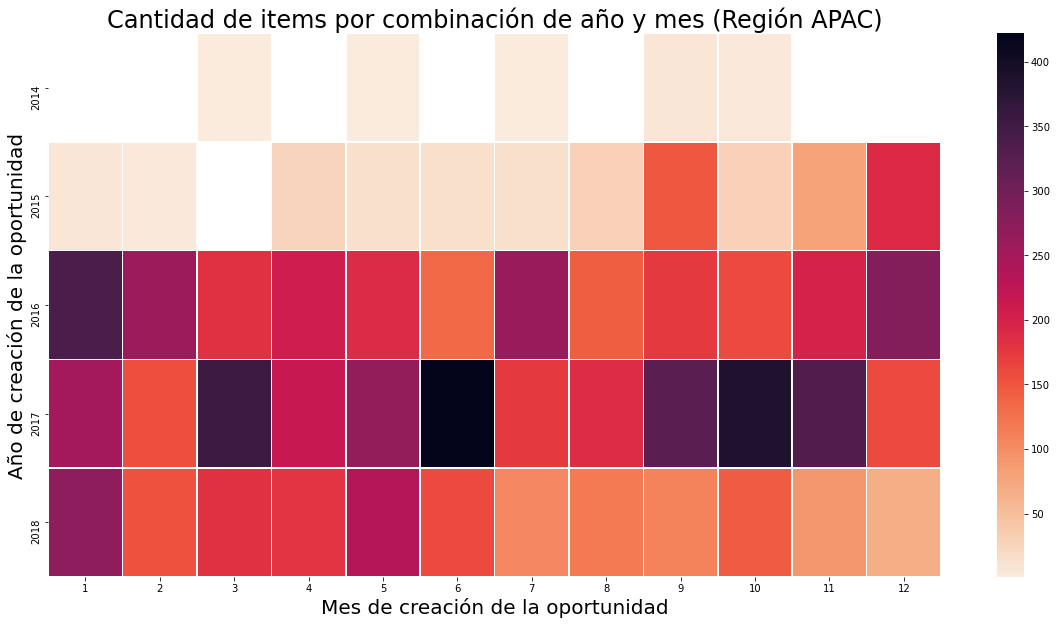

In [28]:
for_heatmap = data_apac.pivot_table(index='AnioUltMod', columns='MesUltMod', values='linea_oportunidad', aggfunc='sum')
fs=20
fst=24
f, ax = plt.subplots(figsize=(20,10))
g = sns.heatmap(for_heatmap,  cmap="rocket_r", linewidths=.5)
g.set_title("Cantidad de items por combinación de año y mes (Región APAC)", fontsize=fst)
g.set_xlabel("Mes de creación de la oportunidad",fontsize=fs)
g.set_ylabel("Año de creación de la oportunidad", fontsize=fs)

Text(159.0, 0.5, 'Año de creación de la oportunidad')

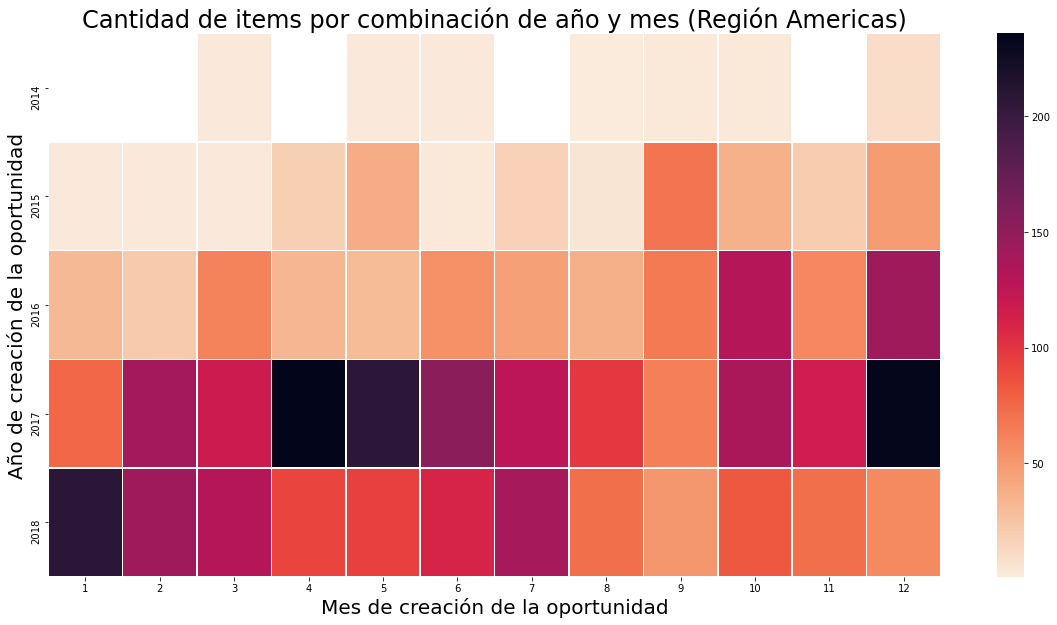

In [29]:
for_heatmap = data_americas.pivot_table(index='AnioUltMod', columns='MesUltMod', values='linea_oportunidad', aggfunc='sum')
fs=20
fst=24
f, ax = plt.subplots(figsize=(20,10))
g = sns.heatmap(for_heatmap,  cmap="rocket_r", linewidths=.5)
g.set_title("Cantidad de items por combinación de año y mes (Región Americas)", fontsize=fst)
g.set_xlabel("Mes de creación de la oportunidad",fontsize=fs)
g.set_ylabel("Año de creación de la oportunidad", fontsize=fs)

### Análisis de la variable TRF

In [30]:
data['Stage_Bool']=(data['Stage']=='Closed Won')

In [31]:
opor_trf=data[['Opportunity_Name','TRF','Stage_Bool']]
opor_trf=opor_trf.groupby('Opportunity_Name').agg({'TRF':'sum','Stage_Bool':'mean'})
opor_trf=opor_trf.reset_index()
porcentaje_trf_0=(len(opor_trf.loc[opor_trf['TRF']==0,:])/len(opor_trf)*100)
print('Porcentaje de oportunidades en las que el valor TRF es nulo: {:.2f}%'.format(porcentaje_trf_0))

Porcentaje de oportunidades en las que el valor TRF es nulo: 61.66%


In [32]:
opor_trf_exit=opor_trf.loc[opor_trf['Stage_Bool']==True,:]
porcentajeExit_trf_0=len(opor_trf_exit.loc[opor_trf_exit['TRF']==0,:])/len(opor_trf_exit)*100
print('Porcentaje de oportunidades exitosas en las que el valor TRF es nulo: {:.2f}%'.format(porcentajeExit_trf_0))

Porcentaje de oportunidades exitosas en las que el valor TRF es nulo: 82.77%


#### Clasificación de productos según TRF nulo o no

In [33]:
#Productos con TRF=0
prodName_trf_0=data.loc[data['TRF']==0,['Product_Name']].value_counts().to_frame()
prodName_trf_0=prodName_trf_0.reset_index()
prodName_trf_0=prodName_trf_0.rename(columns={0:'Frecuencia'})
prodName_trf_0=prodName_trf_0.loc[prodName_trf_0['Frecuencia']!=0,:]
#prodName_trf_0

#Productos con TRF!=0
prodName_trf_1=data.loc[data['TRF']!=0,['Product_Name']].value_counts().to_frame()
prodName_trf_1=prodName_trf_1.reset_index()
prodName_trf_1=prodName_trf_1.rename(columns={0:'Frecuencia'})
prodName_trf_1=prodName_trf_1.loc[prodName_trf_1['Frecuencia']!=0,:]
#prodName_trf_1

#Intersección para verificar que no haya un producto que tenga TRF=0 en una entrada y TRF!=0 en otra
name0name1=prodName_trf_0.merge(prodName_trf_1,how='inner',on='Product_Name')
name0name1

,Product_Name,Frecuencia_x,Frecuencia_y


In [34]:
prodName_trf_0

,Product_Name,Frecuencia
0,Product_Name_100,976
1,Product_Name_226,836
2,Product_Name_231,579
3,Product_Name_491,524
4,Product_Name_4,474
...,...,...
213,Product_Name_34,1
214,Product_Name_41,1
215,Product_Name_346,1
216,Product_Name_39,1


In [35]:
prodName_trf_1

,Product_Name,Frecuencia
0,Product_Name_220,317
1,Product_Name_96,145
2,Product_Name_448,131
3,Product_Name_99,127
4,Product_Name_128,122
...,...,...
233,Product_Name_207,1
234,Product_Name_359,1
235,Product_Name_215,1
236,Product_Name_218,1


### Algoritmo para identificar columnas cuyo valor varía según el item

In [34]:
def oporunique(col):
    parcial=data[['Opportunity_Name',col]].dropna()
    
    comb_count=parcial.value_counts().to_frame()
    comb_count=comb_count.reset_index()
    comb_count=comb_count.loc[comb_count[0]!=0,:]
    
    opor_count=parcial[['Opportunity_Name']].value_counts().to_frame()
    opor_count=opor_count.reset_index()
    opor_count=opor_count.loc[opor_count[0]!=0,:]
    
    numero_op=len(opor_count)
    combinaciones=len(comb_count)
    return (combinaciones-numero_op,combinaciones)

In [35]:
#Columnas que varían su valor por item
columnas=data.columns.to_list()
for col in columnas:
    if col!='Opportunity_Name' and oporunique(col)[0]!=0:
        print('{}: {} ({} combinaciones)\n'.format(col,oporunique(col)[0],oporunique(col)[1]))

Product_Family: 5181 (15022 combinaciones)

Product_Name: 5409 (15250 combinaciones)

ASP(USD): 1041 (10873 combinaciones)

Planned_Delivery_Start_Date: 1407 (11248 combinaciones)

Planned_Delivery_End_Date: 1439 (11223 combinaciones)

Month: 865 (10706 combinaciones)

Delivery_Quarter: 419 (10260 combinaciones)

Delivery_Year: 65 (9906 combinaciones)

TRF: 751 (10592 combinaciones)

Total_Amount: 5905 (15698 combinaciones)

Total_Amount(Million_USD): 5905 (15698 combinaciones)



### A continuación Tops de las variables según su éxito de venta por un lado y monto facturado por otro

In [36]:
data['Stage_Bool']=(data['Stage']=='Closed Won')
def top_by_exit(df,col,minOpor=10,top=10,showPercent=False,cc='violet',titulo='titulo',tamañotit=20,tamañoejes=18,tamañofig=(10,7)):
    dataframe=df[['Opportunity_Name',col,'Stage_Bool']].groupby(['Opportunity_Name',col]).agg({'Stage_Bool':'mean'})
    dataframe=dataframe.reset_index()
    select=dataframe.loc[:,[col,'Stage_Bool']].groupby([col]).agg({'Stage_Bool':['mean','count']})
    select.loc[:,[('Stage_Bool','mean')]]=select['Stage_Bool']['mean']*100
    select.columns=select.columns.get_level_values(0)+'_'+select.columns.get_level_values(1)
    select=select.reset_index()
    select=select.rename(columns={'Stage_Bool_mean':'{}_Exit (%)'.format(col),'Stage_Bool_count':'Number_of_opportunities'})
    select_top=select.loc[select['Number_of_opportunities']>minOpor,:].nlargest(top,'{}_Exit (%)'.format(col)).sort_values('{}_Exit (%)'.format(col))
    if showPercent:
        print('Porcentaje de datos: {}%'.format(percent[col][0]))
    g=select_top.plot(kind='barh', x=col, y='{}_Exit (%)'.format(col), figsize=tamañofig,\
                    rot=0, xlim=(0,100), grid=False, color=cc)
    g.set_title(titulo, fontsize=tamañotit)
    g.set_xlabel('Éxito(%)', fontsize=tamañoejes)
    g.set_ylabel('Región', fontsize=tamañoejes)
    
    return select_top.sort_values('{}_Exit (%)'.format(col),ascending=False).reset_index()
    
def top_by_TotAmount(df,col,minOpor=10,top=10,showPercent=False,cc='violet',titulo='titulo',tamañotit=20,tamañoejes=18,tamañofig=(10,7)):
    dataframe=df.loc[df['Stage_Bool']==True,['Opportunity_Name',col,'Total_Amount(Million_USD)']]
    dataframe=dataframe.groupby(['Opportunity_Name',col]).agg({'Total_Amount(Million_USD)':'sum'})
    dataframe=dataframe.reset_index()
    select=dataframe.loc[:,[col,'Total_Amount(Million_USD)']].groupby([col]).agg({'Total_Amount(Million_USD)':['sum','count']})
    select.columns=select.columns.get_level_values(0)+'_'+select.columns.get_level_values(1)
    select=select.reset_index()
    select=select.rename(columns={'Total_Amount(Million_USD)_sum':'Total (Million USD)','Total_Amount(Million_USD)_count':'Number_of_opportunities'})
    if showPercent:
        print('Porcentaje de datos: {}%'.format(percent[col][0]))
    select_top=select.loc[select['Number_of_opportunities']>minOpor,:].nlargest(top,'Total (Million USD)').sort_values('Total (Million USD)')

    g=select_top.plot(kind='barh', x=col, y='Total (Million USD)', figsize=tamañofig,\
                    rot=0, ylabel='Total (Million USD)', grid=False, color=cc)
    g.set_title(titulo, fontsize=tamañotit)
    g.set_xlabel('Éxito(%)', fontsize=tamañoejes)
    g.set_ylabel('Región', fontsize=tamañoejes)
    return select_top.sort_values('Total (Million USD)',ascending=False).reset_index()

def top_by_AmountPercent(df,col,minOpor=10,top=10,showPercent=False,cc='violet'):
    dataframe=df.loc[df['Stage_Bool']==True,['Opportunity_Name',col,'Total_Amount(Million_USD)']]
    dataframeTot=df[['Opportunity_Name',col,'Total_Amount(Million_USD)']]
    dataframe=dataframe.groupby(['Opportunity_Name',col]).agg({'Total_Amount(Million_USD)':'sum'})
    dataframeTot=dataframeTot.groupby(['Opportunity_Name',col]).agg({'Total_Amount(Million_USD)':'sum'})
    dataframe=dataframe.reset_index()
    dataframeTot=dataframeTot.reset_index()
    data_exit_tot=dataframeTot.merge(dataframe,on=['Opportunity_Name',col],how='outer')
    data_exit_tot=data_exit_tot.fillna(0)
    data_exit_tot=data_exit_tot.rename(columns={'Total_Amount(Million_USD)_x':'Total(Million_USD)','Total_Amount(Million_USD)_y':'Total_Exit(Million_USD)'})
    select=data_exit_tot.loc[:,[col,'Total(Million_USD)','Total_Exit(Million_USD)']].groupby([col])\
    .agg({'Total(Million_USD)':['sum','count'],'Total_Exit(Million_USD)':'sum'})
    select.columns=select.columns.get_level_values(0)+'_'+select.columns.get_level_values(1)
    select=select.reset_index()
    select=select.rename(columns={'Total(Million_USD)_sum':'Total(Million USD)','Total(Million_USD)_count':'Number_of_opportunities',\
                                 'Total_Exit(Million_USD)_sum':'Total_Exit(Million_USD)'})
    select['Percent']=(select['Total_Exit(Million_USD)']/select['Total(Million USD)']*100).round(2)
    select_top=select.loc[select['Number_of_opportunities']>minOpor,:].nlargest(top,'Percent').sort_values('Percent')
    if showPercent:
        print('Porcentaje de datos: {}%'.format(percent[col][0]))
    select_top.plot(kind='barh', x=col, y='Percent', figsize=(10,5),\
                    rot=0, ylabel='%', grid=False,xlim=(0,100), \
                    title='Top {} best {} by %Total_Amount (Min {} opportunities)'.format(len(select_top),col,minOpor),\
                   color=cc)
    return select_top.sort_values('Total(Million USD)',ascending=False).reset_index()

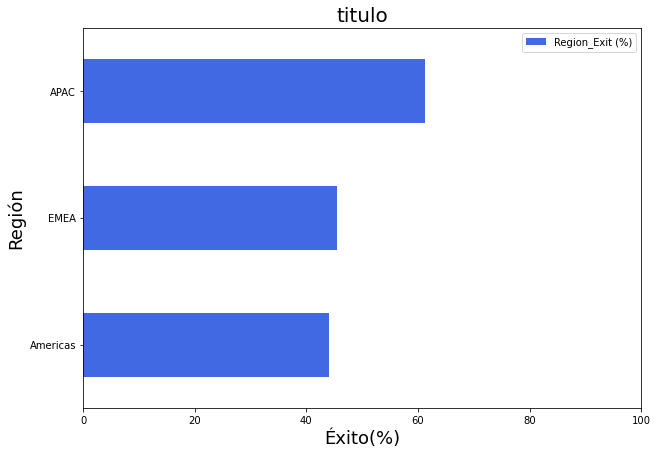

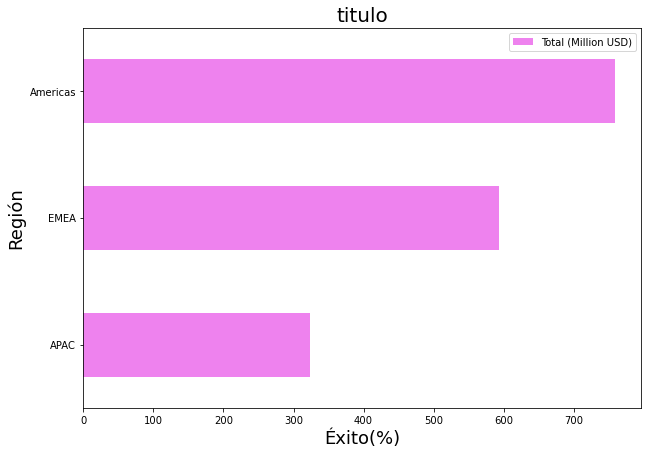

In [37]:
columna='Region'
minimo_oportunidades=0
mejores=20
df_top_by_exit=top_by_exit(data,columna,minOpor=minimo_oportunidades,top=mejores,showPercent=False, cc='royalblue')
df_top_by_TotAmount=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores,cc='violet')

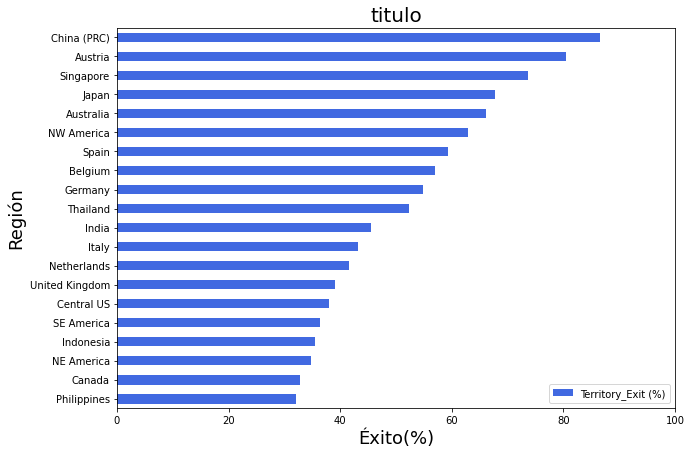

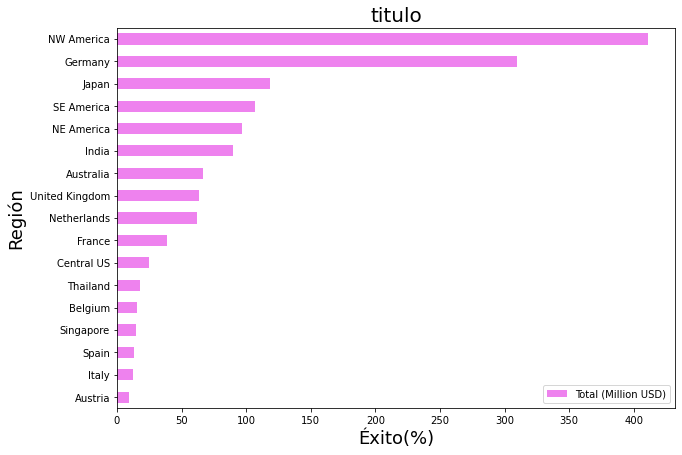

In [38]:
columna='Territory'
minimo_oportunidades=50
mejores=20
df_top_by_exit=top_by_exit(data,columna,minOpor=minimo_oportunidades,top=mejores,showPercent=False, cc='royalblue')
df_top_by_TotAmount=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores,cc='violet')

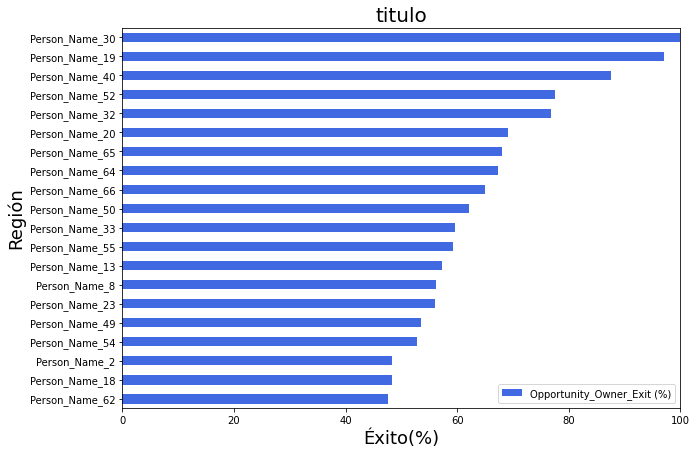

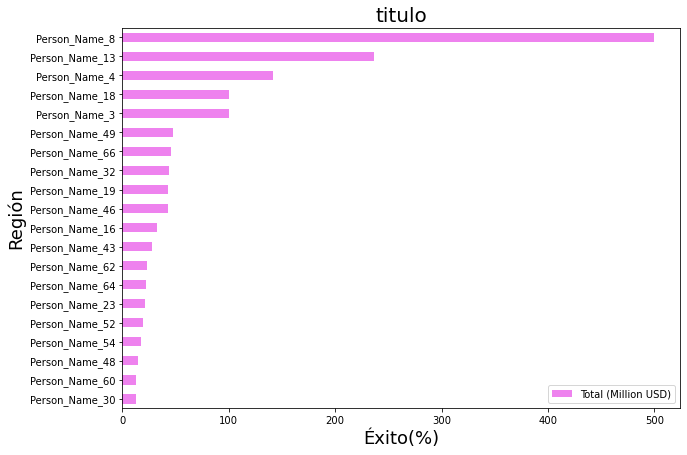

In [39]:
columna='Opportunity_Owner'
minimo_oportunidades=20
mejores=20
df_top_by_exit=top_by_exit(data,columna,minOpor=minimo_oportunidades,top=mejores,showPercent=False, cc='royalblue')
df_top_by_TotAmount=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores,cc='violet')

### Especialización de vendedores

<ipython-input-40-3f1e8e5bbbb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vendedores['oportunidades']=1


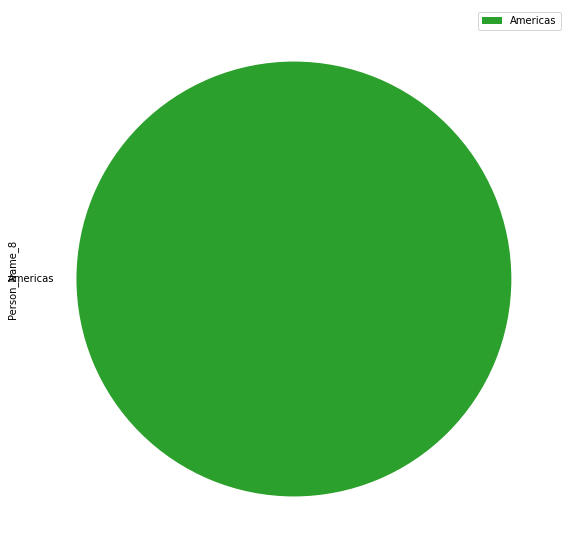

In [40]:
data_vendedores=data[['Opportunity_Name','Region','Opportunity_Owner']]
data_vendedores['oportunidades']=1
data_vendedores=data_vendedores.groupby(['Opportunity_Name','Region','Opportunity_Owner']).agg({'oportunidades':'mean'})
data_oportunidades=data_vendedores.reset_index()
data_opor=data_oportunidades.groupby(['Region','Opportunity_Owner']).agg({'oportunidades':'sum'})
data_opor=data_opor.reset_index()
# data_opor_apac=data_opor.loc[data_opor['Region']=='APAC']
# data_opor_emea=data_opor.loc[data_opor['Region']=='EMEA']
# data_opor_americas=data_opor.loc[data_opor['Region']=='Americas']
data_persona=data_opor.groupby('Opportunity_Owner').agg({'oportunidades':'sum'})
data_persona=data_persona.reset_index()
data_persona=data_persona.rename(columns={'oportunidades':'total'})

data_final=data_persona.merge(data_opor,on='Opportunity_Owner',how='outer')
data_final['% por region']=data_final['oportunidades']/data_final['total']*100
data_final_apac=data_final.loc[data_final['Region']=='APAC',['Opportunity_Owner','% por region']]
data_final_emea=data_final.loc[data_final['Region']=='EMEA',['Opportunity_Owner','% por region']]
data_final_amer=data_final.loc[data_final['Region']=='Americas',['Opportunity_Owner','% por region']]
data_final_apac=data_final_apac.rename(columns={'% por region':'APAC'})
data_final_emea=data_final_emea.rename(columns={'% por region':'EMEA'})
data_final_amer=data_final_amer.rename(columns={'% por region':'Americas'})
data_fin=data_final_apac.merge(data_final_emea,on='Opportunity_Owner',how='outer').merge(data_final_amer,on='Opportunity_Owner',how='outer')
data_fin=data_fin.fillna(0)
data_fin=data_fin.merge(data_persona,on='Opportunity_Owner',how='outer')
data_fin=data_fin.sort_values('total',ascending=False)
data_fin.index = data_fin.Opportunity_Owner
data_fin

g=data_fin.loc[data_fin['total']>10][['APAC','EMEA','Americas']].iloc[1:2].T.plot.pie(subplots=True,figsize=(10,10))

# for_heatmap = data_oportunidades.iloc[0:10].pivot_table(index='Opportunity_Owner', columns='Region', values='oportunidades', aggfunc='sum')
# fs=20
# fst=24
# f, ax = plt.subplots(figsize=(20,10))
# g = sns.heatmap(for_heatmap,  cmap="rocket_r", linewidths=.5)
# g.set_title("Cantidad de items por combinación de año y mes (Región Americas)", fontsize=fst)
# g.set_xlabel("Mes de creación de la oportunidad",fontsize=fs)
# g.set_ylabel("Año de creación de la oportunidad", fontsize=fs)

    

In [41]:
data_fin['total'].to_frame().reset_index()

,Opportunity_Owner,total
0,Person_Name_50,958
1,Person_Name_8,763
2,Person_Name_13,757
3,Person_Name_18,682
4,Person_Name_32,611
5,Person_Name_3,578
6,Person_Name_4,509
7,Person_Name_19,411
8,Person_Name_16,397
9,Person_Name_64,343


### Polarización de vendedores

Porcentaje de datos: 100.0%


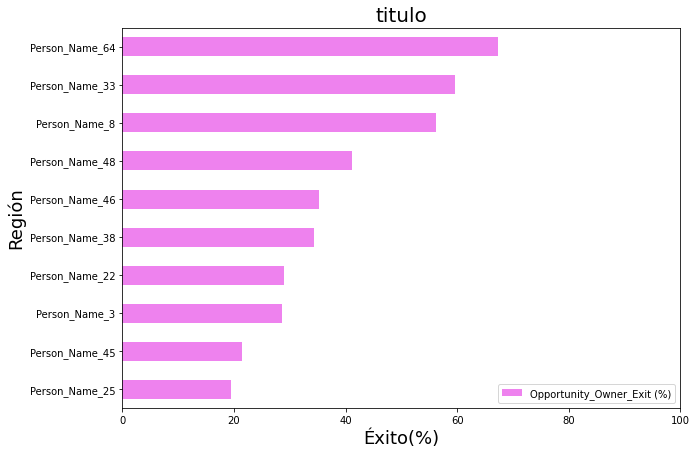

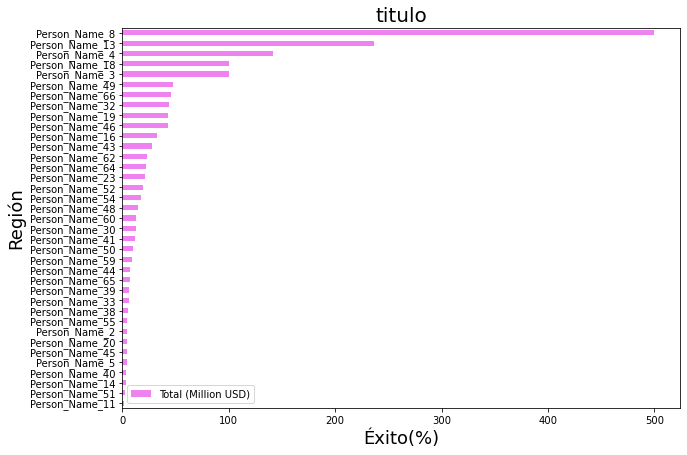

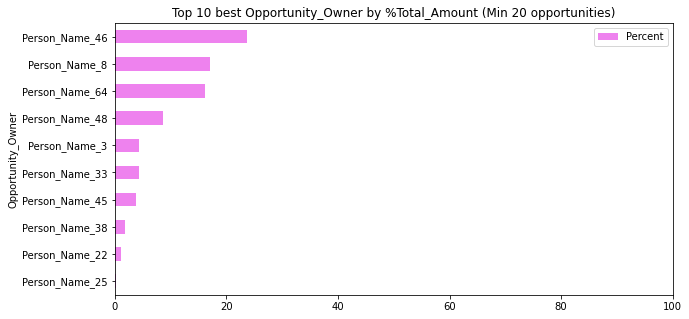

In [42]:
columna='Opportunity_Owner'
region='Americas'
minimo_oportunidades=20
mejores=60
ventas_amer=top_by_exit(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores,showPercent=True)
facturacion_usd_amer=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores)
facturacion_amer=top_by_AmountPercent(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores)
diamante_amer=ventas_amer.merge(facturacion_amer,on=['Opportunity_Owner','Number_of_opportunities'],how='outer')
diamante_amer=diamante_amer.rename(columns={'Percent':'% Facturado','Opportunity_Owner_Exit (%)':'% Ventas'})

(0.0, 105.0)

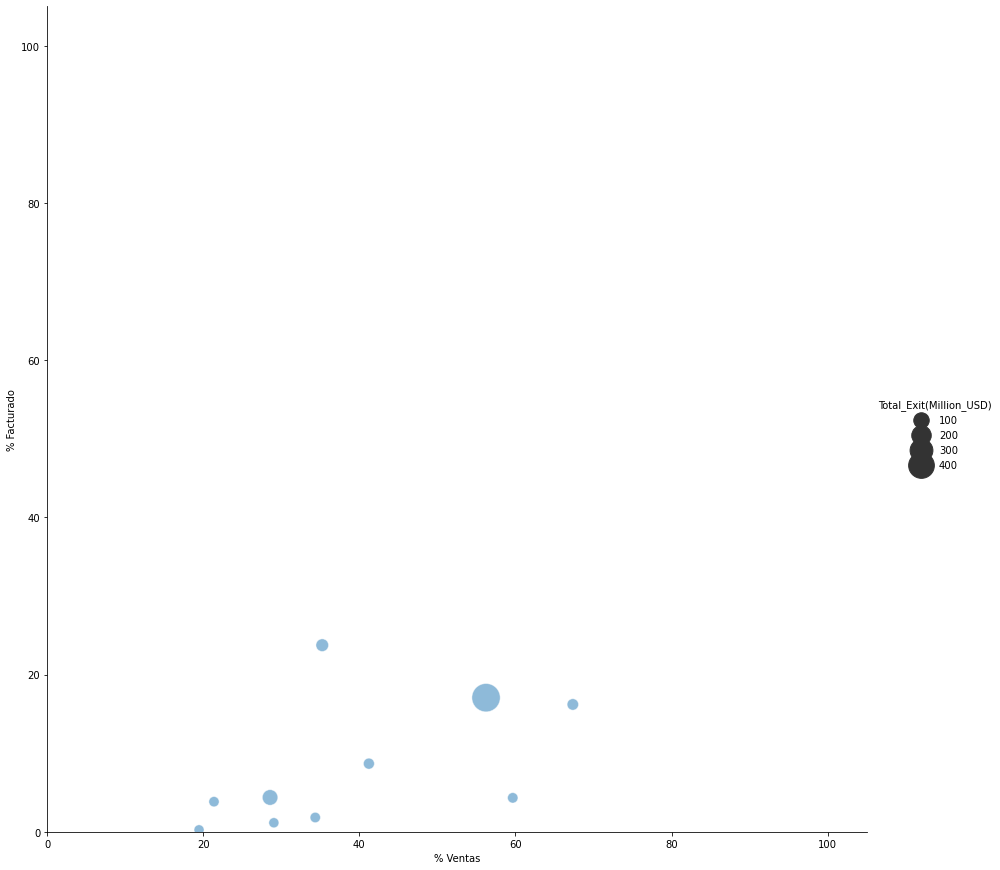

In [43]:
cmap = sns.cubehelix_palette(rot=-0.3, as_cmap=True)
sns.relplot(x="% Ventas", y="% Facturado", size="Total_Exit(Million_USD)",sizes=(100, 800), alpha=.5, palette=cmap,height=12, aspect=1, data=diamante_amer)
plt.ylim(0,105)
plt.xlim(0,105)

Porcentaje de datos: 100.0%


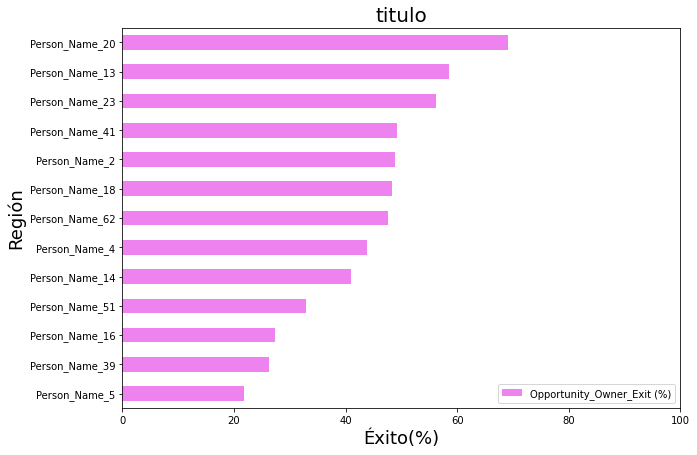

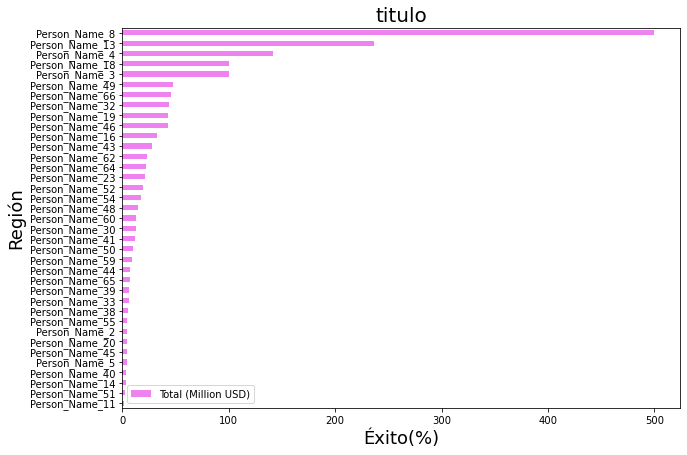

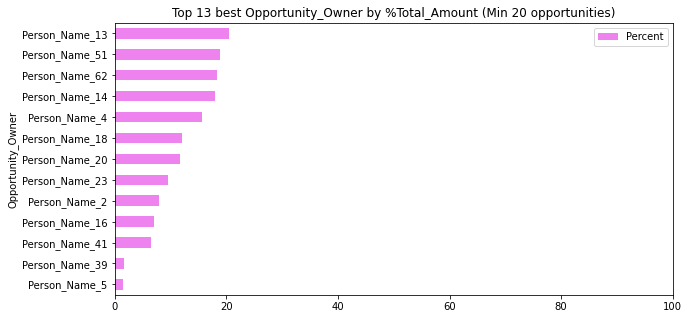

In [44]:
columna='Opportunity_Owner'
region='EMEA'
minimo_oportunidades=20
mejores=60
ventas_emea=top_by_exit(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores,showPercent=True)
facturacion_usd_emea=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores)
facturacion_emea=top_by_AmountPercent(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores)
diamante_emea=ventas_emea.merge(facturacion_emea,on=['Opportunity_Owner','Number_of_opportunities'],how='outer')
diamante_emea=diamante_emea.rename(columns={'Percent':'% Facturado','Opportunity_Owner_Exit (%)':'% Ventas'})

(0.0, 105.0)

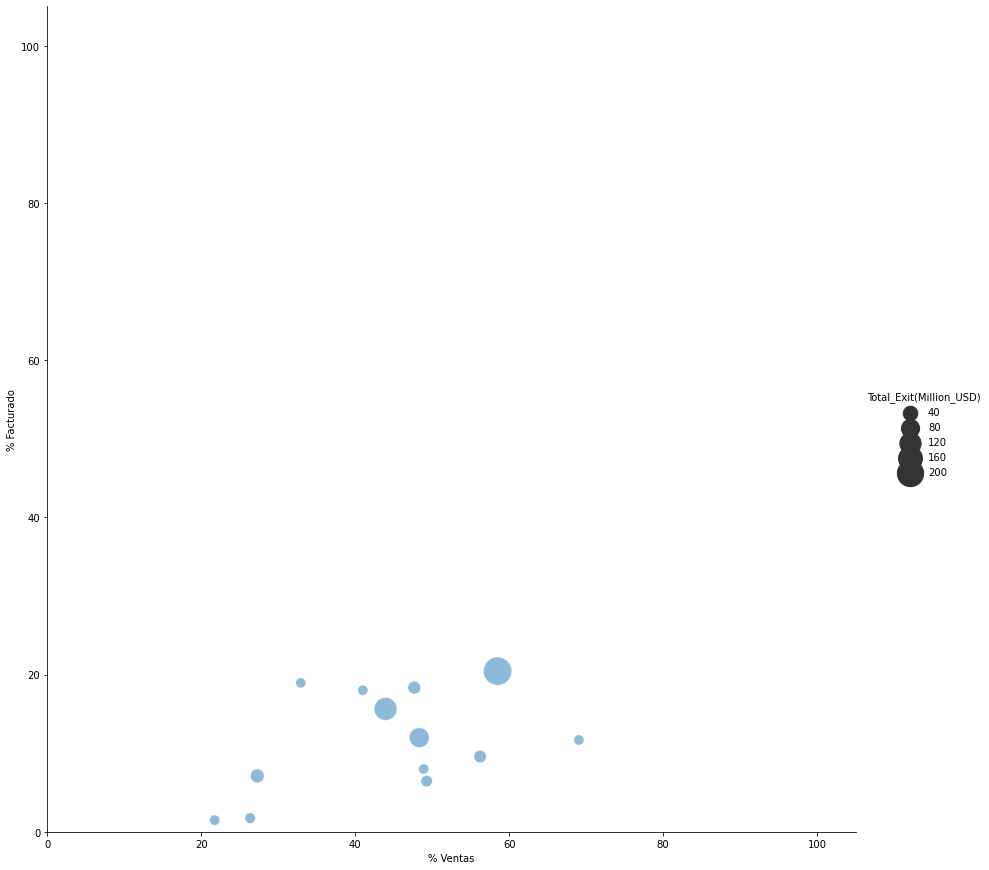

In [45]:
cmap = sns.cubehelix_palette(rot=0.3, as_cmap=True)
sns.relplot(x="% Ventas", y="% Facturado", size="Total_Exit(Million_USD)",sizes=(100, 800), alpha=.5, palette=cmap,height=12, aspect=1, data=diamante_emea)
plt.ylim(0,105)
plt.xlim(0,105)

Porcentaje de datos: 100.0%


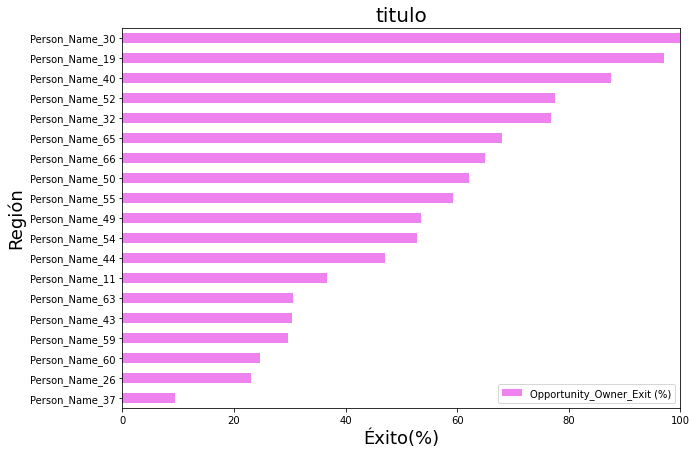

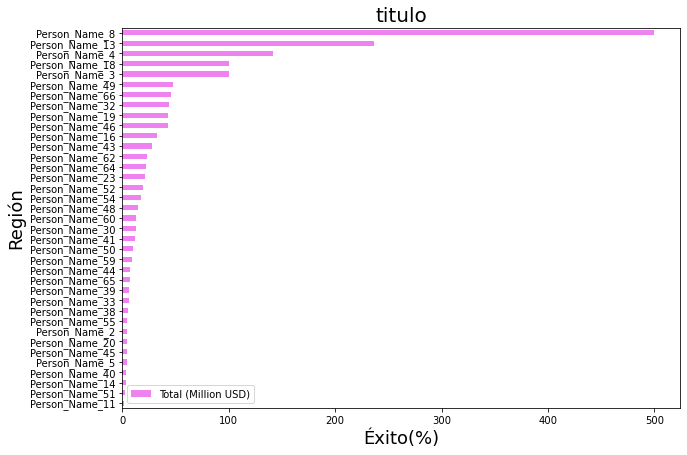

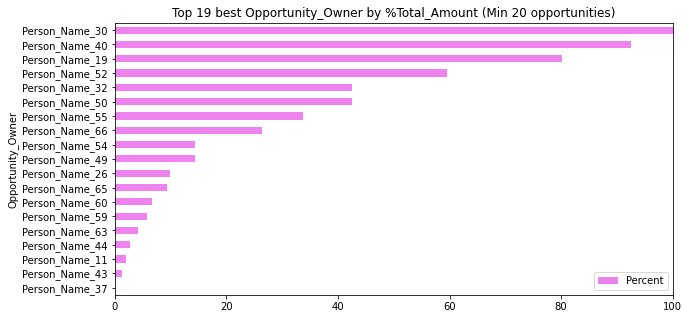

In [46]:
columna='Opportunity_Owner'
region='APAC'
minimo_oportunidades=20
mejores=60
ventas_apac=top_by_exit(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores,showPercent=True)
facturacion_usd_apac=top_by_TotAmount(data,columna,minOpor=minimo_oportunidades,top=mejores)
facturacion_apac=top_by_AmountPercent(data.loc[data['Region']==region,:],columna,minOpor=minimo_oportunidades,top=mejores)
diamante_apac=ventas_apac.merge(facturacion_apac,on=['Opportunity_Owner','Number_of_opportunities'],how='outer')
diamante_apac=diamante_apac.rename(columns={'Percent':'% Facturado','Opportunity_Owner_Exit (%)':'% Ventas'})

In [47]:
diamante_apac['Region']='APAC'
diamante_emea['Region']='EMEA'
diamante_amer['Region']='Americas'
diamante=diamante_apac.append([diamante_emea,diamante_amer])
diamante

,index_x,Opportunity_Owner,% Ventas,Number_of_opportunities,index_y,Total(Million USD),Total_Exit(Million_USD),% Facturado,Region
0,6,Person_Name_30,100.000000,49,6,12.580576,12.580576,100.00,APAC
1,4,Person_Name_19,97.080292,411,4,53.886317,43.165571,80.10,APAC
2,11,Person_Name_40,87.500000,48,11,3.693427,3.419914,92.59,APAC
3,18,Person_Name_52,77.611940,134,18,33.137713,19.741060,59.57,APAC
4,7,Person_Name_32,76.759411,611,7,103.781534,44.189868,42.58,APAC
5,26,Person_Name_65,68.098160,163,26,72.821074,6.866629,9.43,APAC
6,27,Person_Name_66,64.921466,191,27,172.126818,45.449790,26.40,APAC
7,17,Person_Name_50,62.108559,958,17,24.480423,10.391819,42.45,APAC
8,20,Person_Name_55,59.259259,81,20,13.321066,4.502756,33.80,APAC
9,15,Person_Name_49,53.478261,230,15,326.956668,47.189627,14.43,APAC


([<matplotlib.axis.YTick at 0x1d95554cb80>,
 [Text(0, 0, '0'),
  Text(0, 10, '10'),
  Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100')])

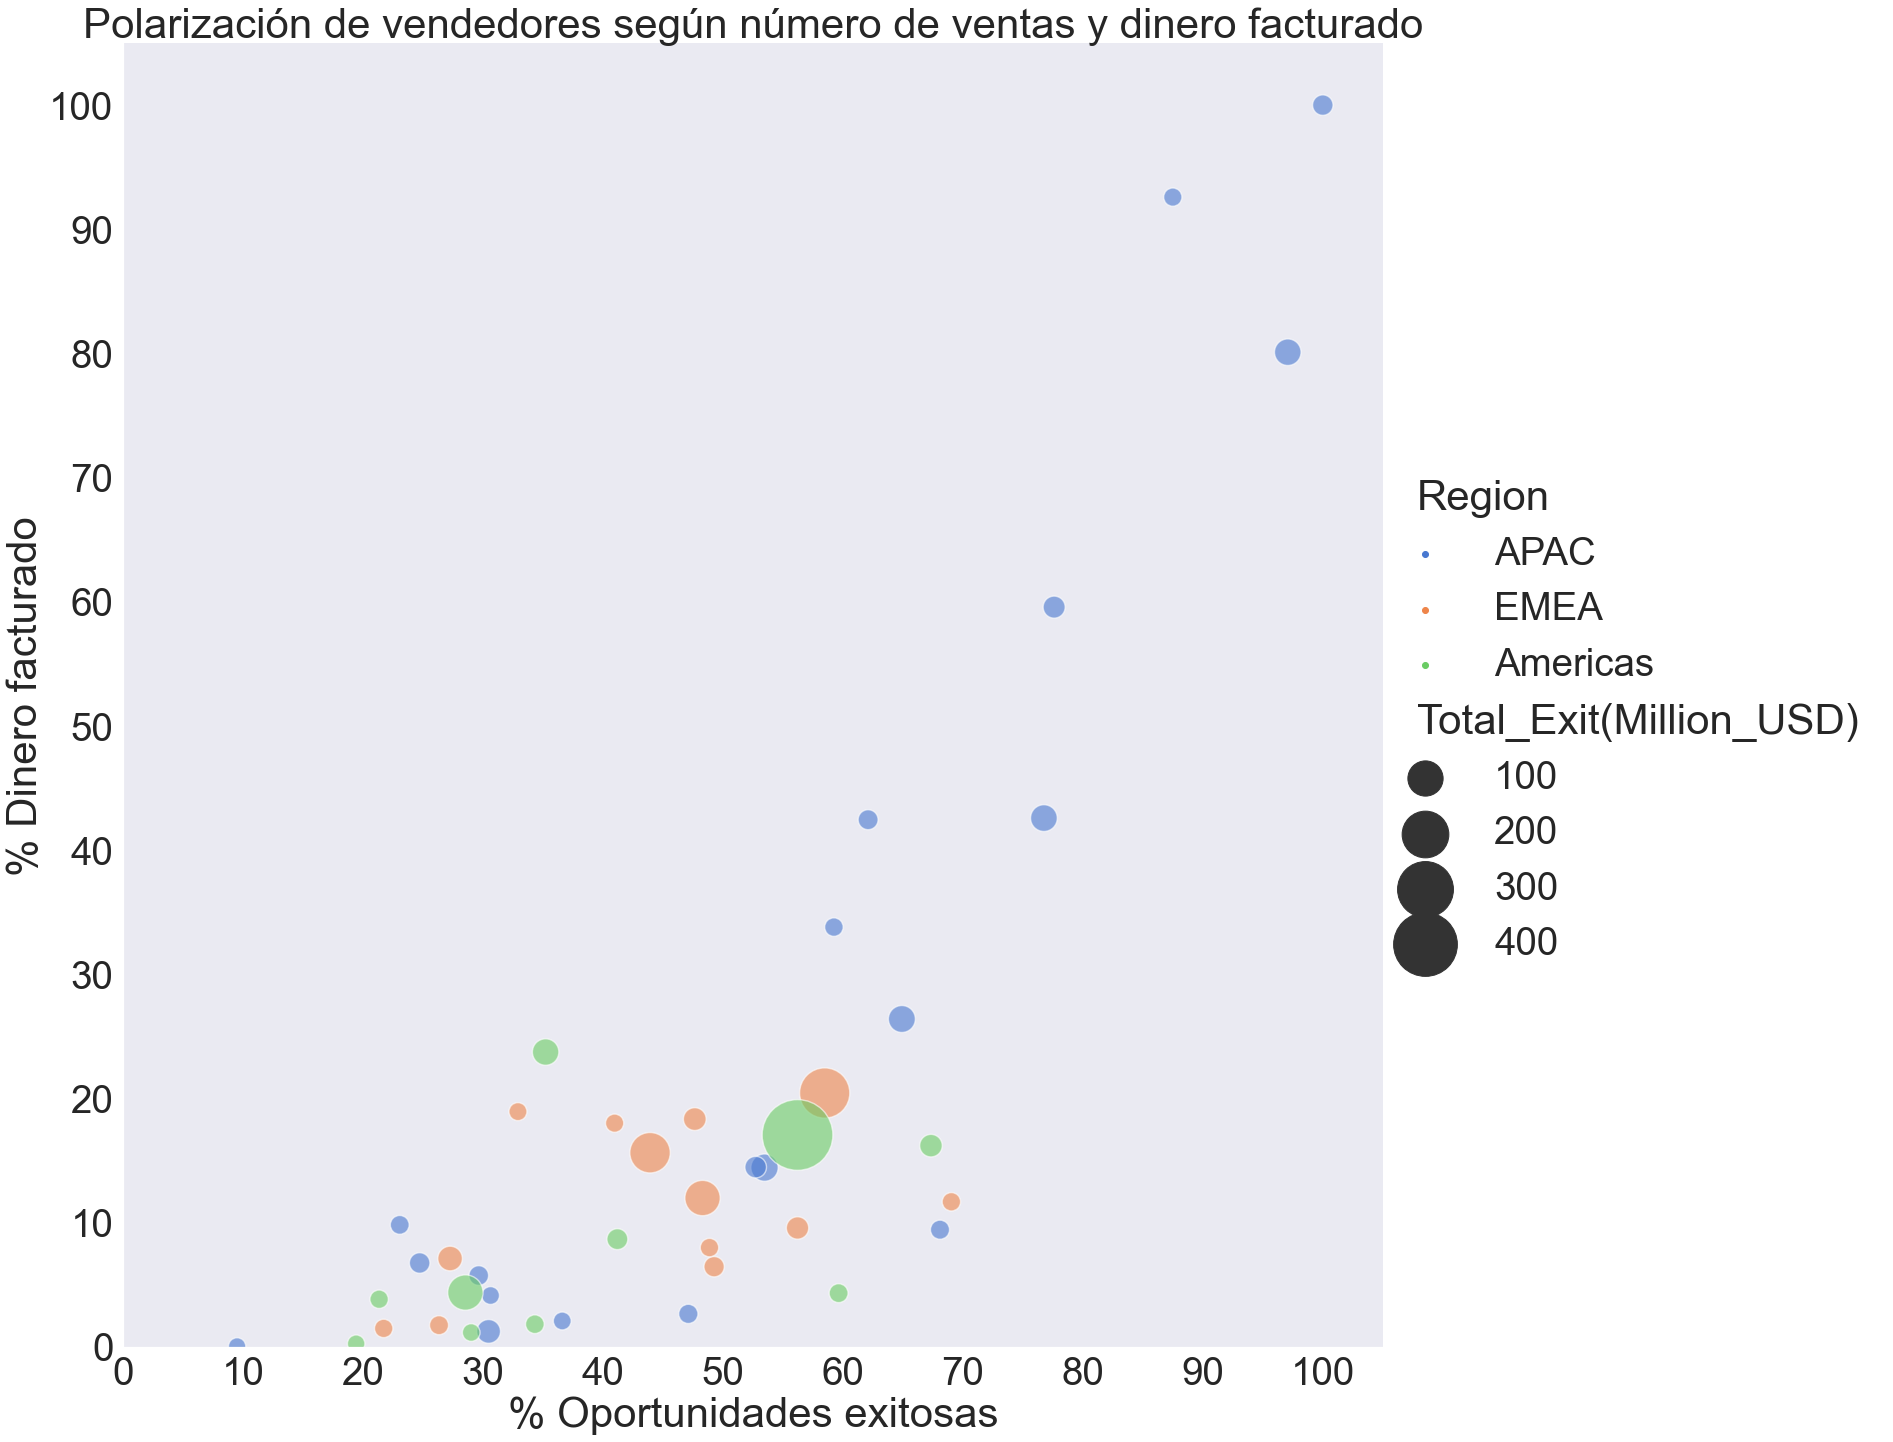

In [48]:
sns.set_theme(style="dark",font_scale=3.5)
g=sns.relplot(x="% Ventas", y="% Facturado", size="Total_Exit(Million_USD)",sizes=(300, 5000), hue='Region',alpha=.6, \
              palette='muted',height=20, aspect=1, data=diamante)
plt.ylim(0,105)
plt.xlim(0,105)
plt.xlabel("% Oportunidades exitosas")
plt.ylabel("% Dinero facturado")
plt.title("Polarización de vendedores según número de ventas y dinero facturado")
plt.xticks(range(0,110,10),range(0,110,10))
plt.yticks(range(0,110,10),range(0,110,10))
#plt.savefig("VisuChallenge.jpg")

In [49]:
diamante.sort_values('% Facturado')

,index_x,Opportunity_Owner,% Ventas,Number_of_opportunities,index_y,Total(Million USD),Total_Exit(Million_USD),% Facturado,Region
18,8,Person_Name_37,9.523810,21,8,19.771223,0.006608,0.03,APAC
9,7,Person_Name_25,19.444444,36,7,224.561518,0.550256,0.25,Americas
6,5,Person_Name_22,29.032258,31,5,110.152344,1.271174,1.15,Americas
14,13,Person_Name_43,30.483271,269,13,2269.713539,28.063182,1.24,APAC
12,16,Person_Name_5,21.739130,138,16,274.664467,4.058262,1.48,EMEA
11,12,Person_Name_39,26.351351,148,12,372.383508,6.475916,1.74,EMEA
5,11,Person_Name_38,34.337349,166,11,282.362283,5.149364,1.82,Americas
12,1,Person_Name_11,36.619718,71,1,91.520534,1.904933,2.08,APAC
11,14,Person_Name_44,47.126437,174,14,279.149376,7.410594,2.65,APAC
8,14,Person_Name_45,21.359223,103,14,108.071639,4.141135,3.83,Americas


### Relación entre Total_Amount TRF y ASP

In [51]:
def colVScol(df,colx,coly,titulo='Sin título',tamañofig=(20,20),titTam=12, labelTam=10,):
    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # TODO: indicar referencias de colores
    columnas=df[[colx,coly]].dropna()
    sns.set_theme()    
    g = sns.regplot(x=colx, y=coly, data=columnas, color="lightgreen")
    #g = sns.regplot(x="goal_log", y="pledged_log", 
    #                    data=failed, color="orange")
    g.set_title(titulo, fontsize=titTam)
    g.set_xlabel(colx, fontsize=labelTam)
    g.set_ylabel(coly, fontsize=labelTam)
    g.figure.set_size_inches(10, 10)
    plt.xticks(fontsize=labelTam)
    plt.yticks(fontsize=labelTam)
    
    #g.set_xticklabels(g.get_xticklabels(),rotation=90)

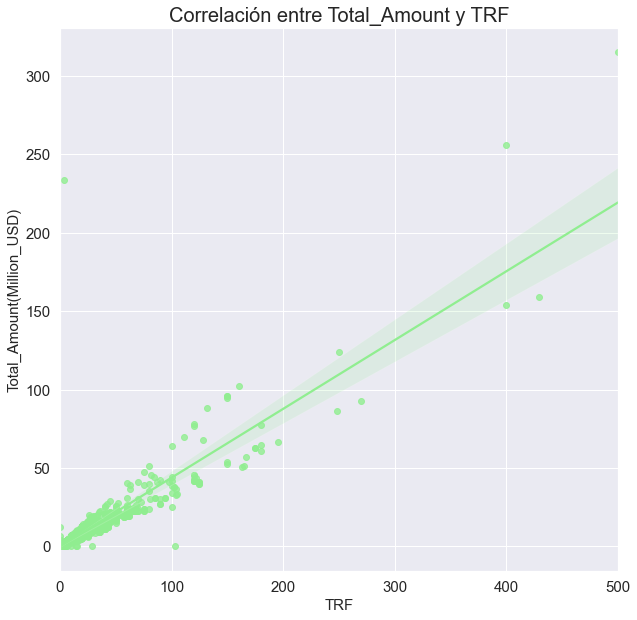

In [52]:
colVScol(data,'TRF','Total_Amount(Million_USD)',titulo='Correlación entre Total_Amount y TRF',tamañofig=(20,20),titTam=20,labelTam=15)


En el gráfico anterior puede verse claramente que hay un valor fuera de la tendencia, al observar la columna 'ASP(USD)' el valor correspondiente difiere del resto en un factor de 1/100

In [53]:
data.select_dtypes(include=['number']).loc[data['ASP(USD)']>2,:]

,Sales_Contract_No,ASP(USD),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Last_Modified_Year,Total_Amount(Million_USD),Total_Taxable_Amount(Million_USD),linea_oportunidad,MesUltMod,AnioUltMod
7287,116.0,67.00000,2016,0,12194000.0,1.356339e+09,2016,12.1940,12.391181,1,2,2016
9598,NaN,57.68578,2016,4,216240000.0,2.162400e+08,2016,233.5392,233.539200,1,2,2016


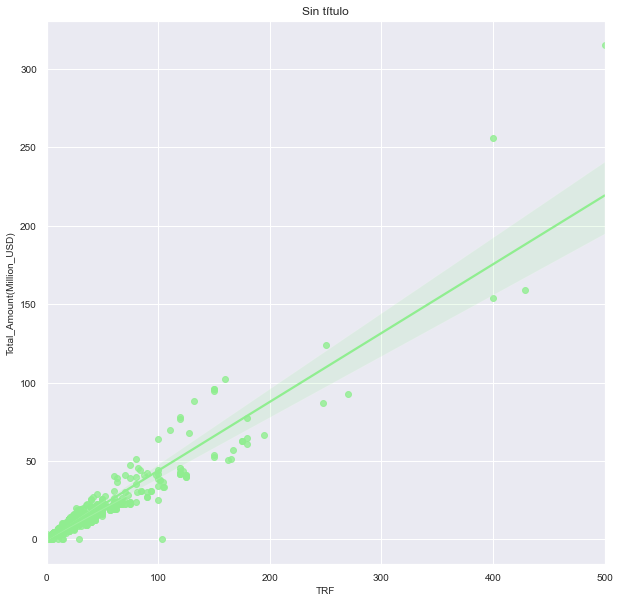

In [54]:
#Descartamos las filas mostradas en la celda anterior
data=data.loc[data['ASP(USD)']<2,:]
colVScol(data,'TRF','Total_Amount(Million_USD)')

Al observar una tendencia lineal podemos concluir que Total_Amount(USD) y TRF son coherentes.
También se puede observar que hay una filas cuyo Total_Amount=0, esto debe ser un error que también descartaremos.

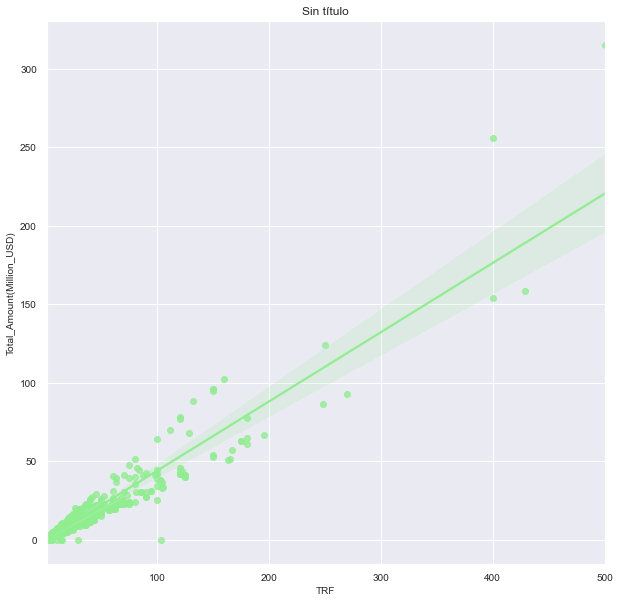

In [55]:
data_trf_no0=data=data.loc[data['TRF']!=0,:]
colVScol(data_trf_no0,'TRF','Total_Amount(Million_USD)')

In [56]:
año=2016
colVScol(data.loc[data['Last_Modified_Date'].dt.year==año,:],'TRF','Total_Amount(USD)',titulo=año)

KeyError: "['Total_Amount(USD)'] not in index"

In [ ]:
año=2017
colVScol(data.loc[data['Last_Modified_Date'].dt.year==año,:],'TRF','Total_Amount(USD)',titulo=año)

In [ ]:
año=2018
colVScol(data.loc[data['Last_Modified_Date'].dt.year==año,:],'TRF','Total_Amount(USD)',titulo=año)

### Relación entre Total_Amount y Total_Taxable_Amount
A continuación se grafican las oportunidades en las que no se cumple que Total_Taxable_Amount=Suma de montos de items por oportunidad (Total_Amount) y en las que si

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


80.30222693531283

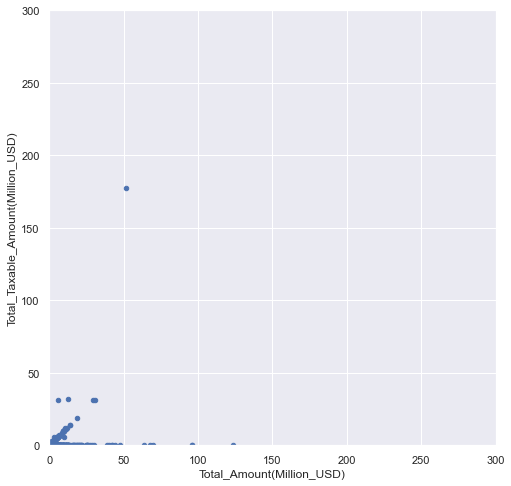

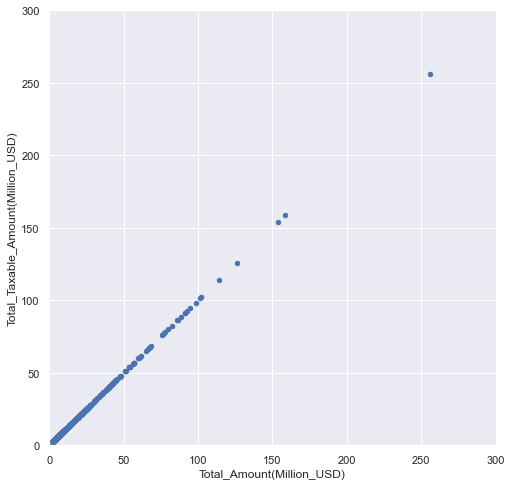

In [57]:
data_totax=data[['Opportunity_Name','Total_Amount(Million_USD)','Total_Taxable_Amount(Million_USD)']]
data_totax=data_totax.groupby('Opportunity_Name').agg({'Total_Amount(Million_USD)':'sum','Total_Taxable_Amount(Million_USD)':'mean'})
data_totax['Contador']=1
crit=0.01
figtam=8
data_totax_iguales=data_totax.loc[np.abs(data_totax['Total_Taxable_Amount(Million_USD)']-data_totax['Total_Amount(Million_USD)'])<crit,:]
data_totax_dist=data_totax.loc[np.abs(data_totax['Total_Taxable_Amount(Million_USD)']-data_totax['Total_Amount(Million_USD)'])>crit,:]
data_totax_dist.plot(x='Total_Amount(Million_USD)',y='Total_Taxable_Amount(Million_USD)',figsize=(figtam,figtam),kind='scatter',xlim=(0,300),ylim=(0,300))
data_totax_iguales.plot(x='Total_Amount(Million_USD)',y='Total_Taxable_Amount(Million_USD)',figsize=(figtam,figtam),kind='scatter',xlim=(0,300),ylim=(0,300))

total=len(data_totax)
iguales=len(data_totax_iguales)
distintos=len(data_totax_dist)
iguales/total*100

In [58]:
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

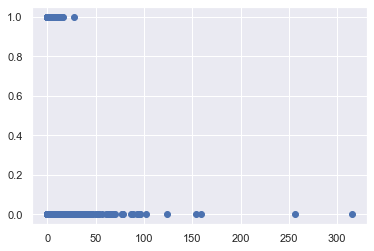

In [59]:
pruebaknn = data[["Total_Amount(Million_USD)", "Stage_Bool"]]
plt.scatter(data["Total_Amount(Million_USD)"], data["Stage_Bool"])

In [60]:
X = data.values

In [61]:
# instantiate model
nbrs = NearestNeighbors(n_neighbors = 3)
# fit model
nbrs.fit(X)

ValueError: could not convert string to float: 'EMEA'

In [ ]:
###TP2

In [61]:
#Empezamos con XGBoost
!pip3 install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [62]:
data

,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP(USD),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Last_Modified_Year,Last_Modified_Quarter,Total_Amount(Million_USD),Total_Taxable_Amount(Million_USD),linea_oportunidad,MesUltMod,AnioUltMod,Stage_Bool
0,EMEA,NaN,True,True,True,True,Bureaucratic_Code_4,2015-06-16,NaN,Netherlands,Account_Name_619,Opportunity_Name_12598,NaN,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,2016-01-30,2016-06-13,Person_Name_18,Product_Family_77,Product_Name_99,0.58817,2016-05-01,2016-06-30,2016-05-01,Q2,2016,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,2016,Q2,5.958264,5.958264,1,12,2015,False
1,EMEA,Germany,True,True,True,True,Bureaucratic_Code_4,2015-12-15,Source_13,Germany,Account_Name_2000,Opportunity_Name_777,NaN,Person_Name_13,Person_Name_13,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_2,2015-12-17,2016-04-01,2016-04-08,Person_Name_13,Product_Family_77,Product_Name_98,0.55424,2016-05-01,2016-06-30,2016-05-01,Q2,2016,20,EUR,9809800.0,EUR,9809800.0,Closed Lost,2016,Q2,11.085074,11.085074,1,12,2015,False
2,EMEA,Belgium,True,False,False,False,Bureaucratic_Code_5,2014-02-25,NaN,Belgium,Account_Name_825,Opportunity_Name_5376,NaN,Person_Name_18,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-18,2016-04-30,2016-06-17,Person_Name_18,Product_Family_77,Product_Name_96,0.58817,2016-06-01,2016-06-30,2016-06-01,Q2,2016,1,EUR,304200.0,EUR,304200.0,Closed Lost,2016,Q2,0.343746,0.343746,1,12,2015,False
3,EMEA,NaN,True,False,True,False,Bureaucratic_Code_5,2014-02-25,NaN,Belgium,Account_Name_825,Opportunity_Name_5377,NaN,Person_Name_18,Person_Name_23,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-18,2016-01-30,2016-04-11,Person_Name_23,Product_Family_116,Product_Name_163,0.62210,2016-06-01,2016-06-30,2016-06-01,Q2,2016,1,EUR,500500.0,EUR,500500.0,Closed Lost,2016,Q2,0.565565,0.565565,1,12,2015,False
4,EMEA,Germany,True,False,True,False,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_9280,NaN,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-01-20,NaT,2016-05-24,Person_Name_13,Product_Family_77,Product_Name_96,0.58817,2016-05-02,2016-05-27,2016-05-01,Q2,2016,1,EUR,473200.0,EUR,473200.0,Closed Lost,2016,Q2,0.534716,0.534716,1,1,2015,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,EMEA,United Kingdom,True,True,True,True,Bureaucratic_Code_4,2015-09-11,Source_7,United Kingdom,Account_Name_74,Opportunity_Name_4693,NaN,Person_Name_18,Person_Name_39,Account_Type_2,Opportunity_Type_20,Non Binding,Delivery_Terms_2,2015-09-11,2015-10-06,2016-09-05,Person_Name_39,Product_Family_77,Product_Name_97,0.57686,2016-03-04,2016-03-15,2016-03-01,Q1,2016,2,EUR,1021020.0,EUR,1531530.0,Closed Lost,2016,Q3,1.143542,1.715314,1,9,2015,False
16943,EMEA,United Kingdom,True,True,True,True,Bureaucratic_Code_4,2015-09-11,Source_7,United Kingdom,Account_Name_74,Opportunity_Name_4693,NaN,Person_Name_18,Person_Name_39,Account_Type_2,Opportunity_Type_20,Non Binding,Delivery_Terms_2,2015-09-11,2015-10-06,2016-09-05,Person_Name_39,Product_Family_77,Product_Name_96,0.57686,2016-02-08,2016-02-18,2016-02-01,Q1,2016,1,EUR,510510.0,EUR,1531530.0,Closed Lost,201

In [106]:
#Todas las variables que podamos pasar a numero, las pasamos
Stage_Bool={'False': '0'}
Stage_Bool={'True': '1'}
data['Stage_Bool'].value_counts()

False    3678
True     1297
Name: Stage_Bool, dtype: int64

In [ ]:
# borrador
random = np.random.randint(1, 10000, size=3731)
df = pd.DataFrame(data, columns=['Random'])

In [152]:
#df_train =pd.read_csv('Entrenamieto_ECI_2020.csv'),usecols=['ASP(USD)', 'TRF', 'Stage', 'Total_Amount(Million_USD)', 'Total_Taxable_Amount(Million_USD)', 'MesUltMod', 'AnioUltMod']
df_train = data[['ASP(USD)', 'TRF', 'Stage_Bool', 'Total_Amount(Million_USD)', 'Total_Taxable_Amount(Million_USD)', 'MesUltMod', 'AnioUltMod']]
df_train['Stage_Bool'] = df_train['Stage_Bool']*1
df_train['ASP(USD)'].astype('float32')
df_train


<ipython-input-152-b06ec8075658>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Stage_Bool'] = df_train['Stage_Bool']*1


,ASP(USD),TRF,Stage_Bool,Total_Amount(Million_USD),Total_Taxable_Amount(Million_USD),MesUltMod,AnioUltMod
0,0.58817,10,0,5.958264,5.958264,12,2015
1,0.55424,20,0,11.085074,11.085074,12,2015
2,0.58817,1,0,0.343746,0.343746,12,2015
3,0.62210,1,0,0.565565,0.565565,12,2015
4,0.58817,1,0,0.534716,0.534716,1,2015
...,...,...,...,...,...,...,...
16942,0.57686,2,0,1.143542,1.715314,9,2015
16943,0.57686,1,0,0.571771,1.715314,9,2015
16944,0.48637,14,0,6.936966,6.936966,10,2015
16945,0.50334,16,0,8.122674,8.122674,10,2015


In [153]:
df_train.dtypes

ASP(USD)                             float64
TRF                                    int16
Stage_Bool                             int32
Total_Amount(Million_USD)            float64
Total_Taxable_Amount(Million_USD)    float64
MesUltMod                              int64
AnioUltMod                             int64
dtype: object

TypeError: 'numpy.dtype' object is not callable

In [158]:
Y = df_train['Stage_Bool'] # prediction 
df_train = df_train.drop(columns=['Stage_Bool']) 
X = df_train #Train local 

x_train, x_test, y_train, y_test = train_test_split(X,Y)
y_train

2733     0
10726    0
13829    1
13487    1
15235    0
        ..
212      1
9156     1
15657    1
10980    1
1279     0
Name: Stage_Bool, Length: 3731, dtype: int32

In [94]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.6, max_depth = 6, alpha = 5, n_estimators = 200)
xg_reg.fit(x_train,y_train)
Y_pred = xg_reg.predict(x_test)
print(xg_reg.score(x_test,y_test))
print(xg_reg.score(x_train,y_train))

[19:37:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7998392282958199
0.8271240954167783


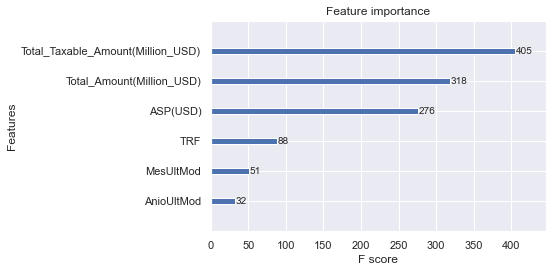

In [103]:
plot = xgb.plot_importance(xg_reg) 
mplt.gcf().subplots_adjust(bottom=0.15) 
fig = plot.get_figure()
fig.savefig("XgboostFI.png")

In [142]:
#Probamos con CatBoost
# !pip install catboost
from catboost import CatBoostClassifier


In [143]:
# CAT BOOST 
catb = CatBoostClassifier()
catb.fit(x_train, y_train)
preds = catb.predict(x_test)
print(catb.score(x_test,y_test))
print(catb.score(x_train,y_train))

Learning rate set to 0.084623
0:	learn: 1.4458461	total: 213ms	remaining: 3m 32s
1:	learn: 1.3205040	total: 219ms	remaining: 1m 49s
2:	learn: 1.2191026	total: 226ms	remaining: 1m 14s
3:	learn: 1.1353442	total: 234ms	remaining: 58.2s
4:	learn: 1.0666289	total: 239ms	remaining: 47.5s
5:	learn: 1.0079241	total: 243ms	remaining: 40.3s
6:	learn: 0.9563204	total: 249ms	remaining: 35.3s
7:	learn: 0.9130153	total: 254ms	remaining: 31.5s
8:	learn: 0.8739349	total: 259ms	remaining: 28.5s
9:	learn: 0.8408395	total: 264ms	remaining: 26.1s
10:	learn: 0.8109447	total: 269ms	remaining: 24.1s
11:	learn: 0.7840911	total: 273ms	remaining: 22.5s
12:	learn: 0.7596478	total: 278ms	remaining: 21.1s
13:	learn: 0.7368467	total: 283ms	remaining: 19.9s
14:	learn: 0.7166409	total: 288ms	remaining: 18.9s
15:	learn: 0.6979645	total: 293ms	remaining: 18s
16:	learn: 0.6819583	total: 300ms	remaining: 17.3s
17:	learn: 0.6656006	total: 313ms	remaining: 17.1s
18:	learn: 0.6518548	total: 320ms	remaining: 16.5s
19:	learn:

In [155]:
# cat regressor
from catboost import CatBoostRegressor
model = CatBoostRegressor()
model.fit(x_train, y_train)
preds = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/private/libs/target/target_converter.cpp:37: Target value "Closed Lost" cannot be parsed as float

In [74]:
#Decision Trees (esto no lo aprendi a usar)
# from sklearn.tree import DecisionTreeClassifier

# X = df_train
# y = df_train["Stage_Bool"]
# tree_clf = DecisionTreeClassifier(max_depth=2)
# tree_clf.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# from sklearn.tree import export_graphviz
# export_graphviz(
# tree_clf,
# out_file=image_path("iris_tree.dot"),
# feature_names=iris.feature_names[2:],
# class_names=iris.target_names,
# rounded=True,
# filled=True
# )
# $ dot -Tpng iris_tree.dot -o iris_tree.png

In [145]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(x_train, y_train)
preds = rf_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').